## **Part 1: Import Libraries**

In [32]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt


## **Part 2: Load and Explore Data**

> Add blockquote



In [33]:
data_path = "data.csv"
df = pd.read_csv(data_path)

target_column = "Target"


X = df.drop(columns=[target_column])
y = df[target_column]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Target                         70000 non-null  object
 1   Genetic Markers                70000 non-null  object
 2   Autoantibodies                 70000 non-null  object
 3   Family History                 70000 non-null  object
 4   Environmental Factors          70000 non-null  object
 5   Insulin Levels                 70000 non-null  int64 
 6   Age                            70000 non-null  int64 
 7   BMI                            70000 non-null  int64 
 8   Physical Activity              70000 non-null  object
 9   Dietary Habits                 70000 non-null  object
 10  Blood Pressure                 70000 non-null  int64 
 11  Cholesterol Levels             70000 non-null  int64 
 12  Waist Circumference            70000 non-null  int64 
 13  B

## **Part 3: Data Visualization**


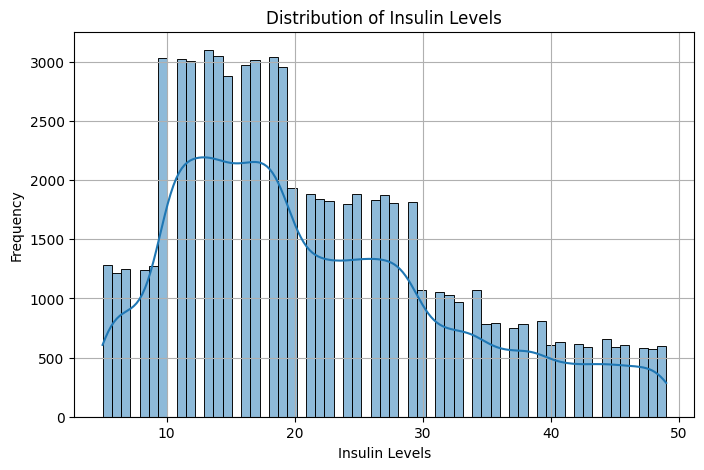

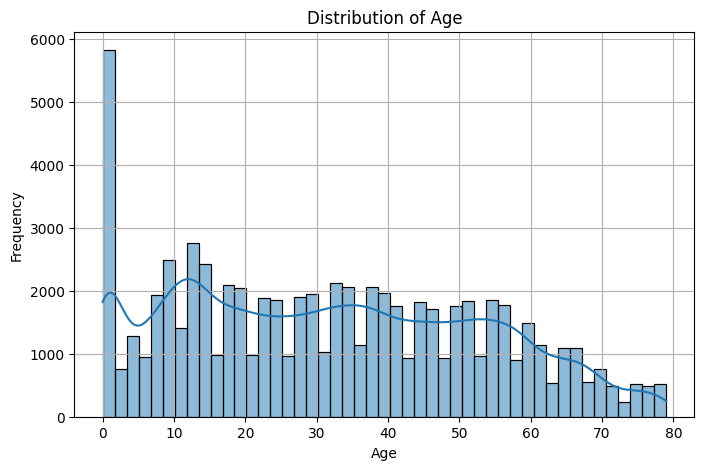

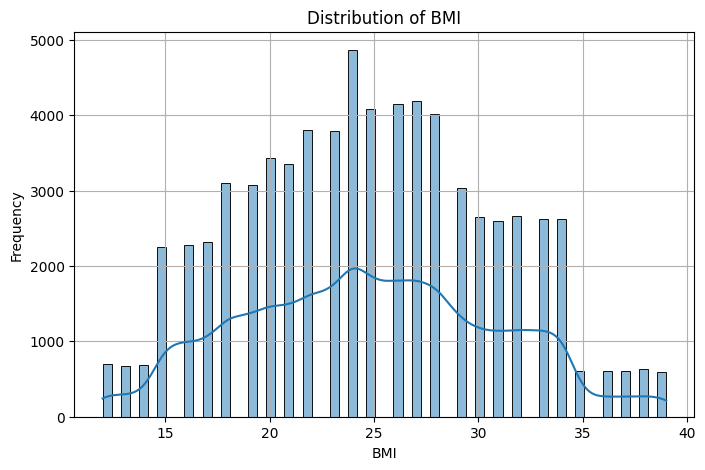

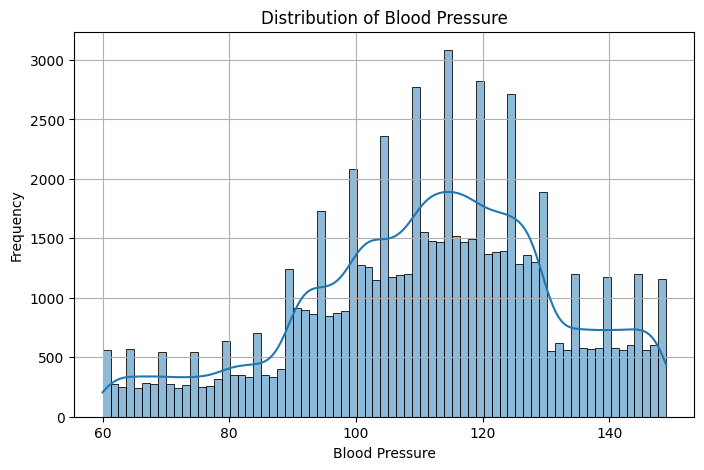

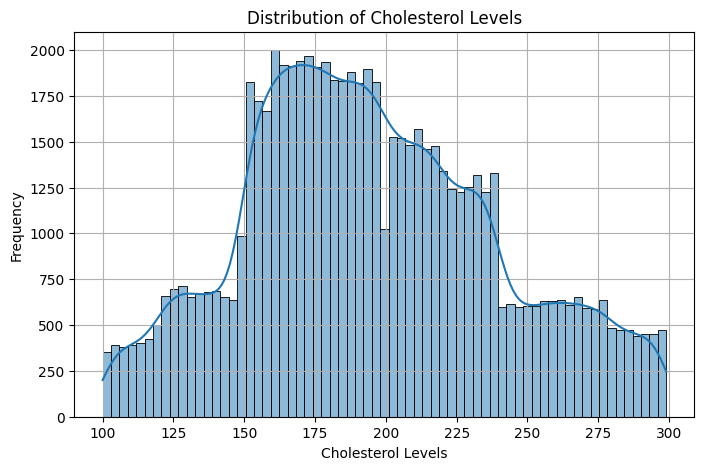

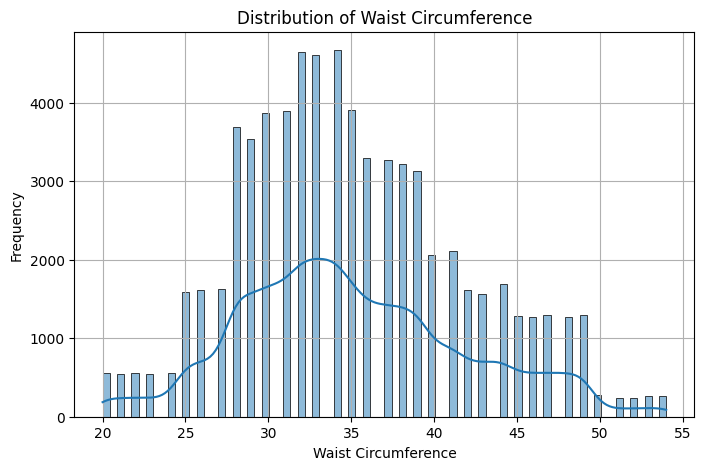

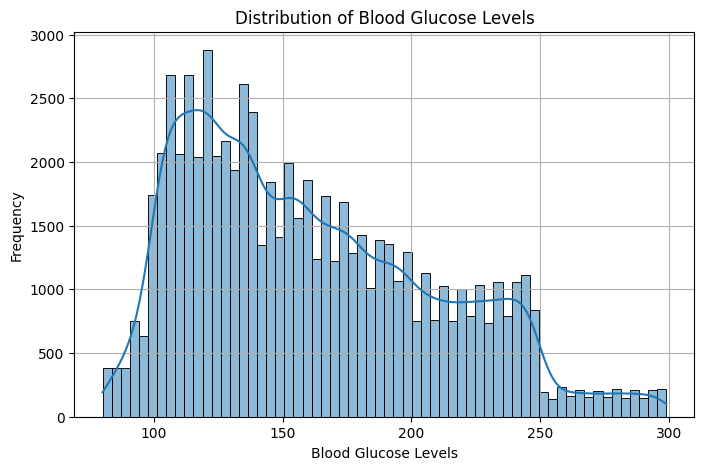

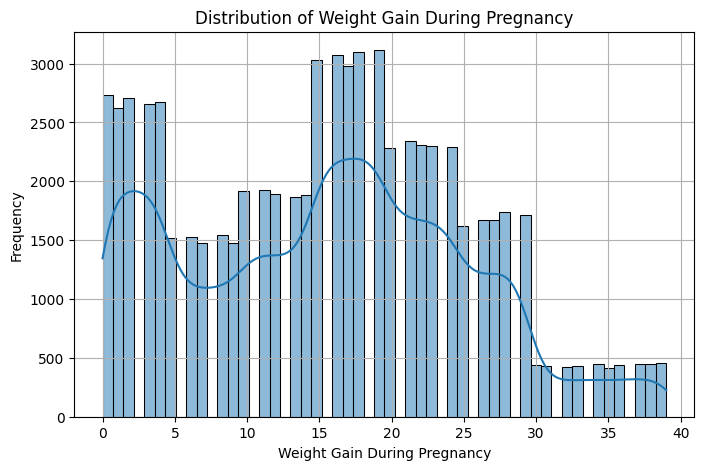

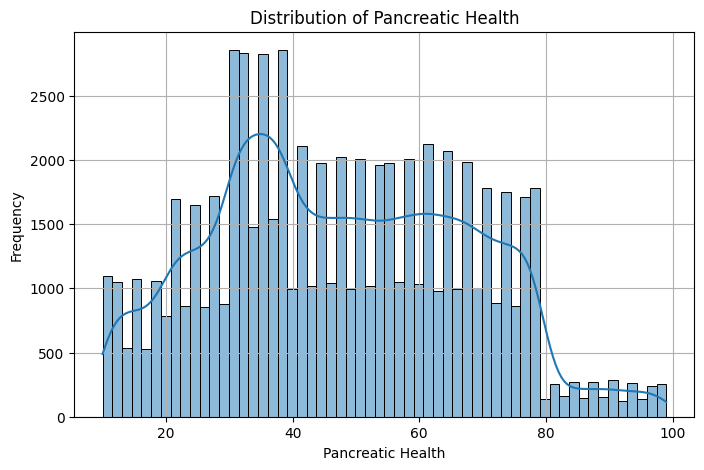

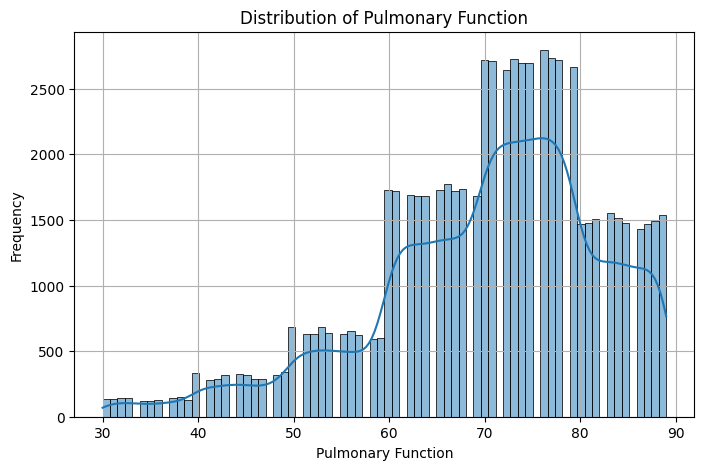

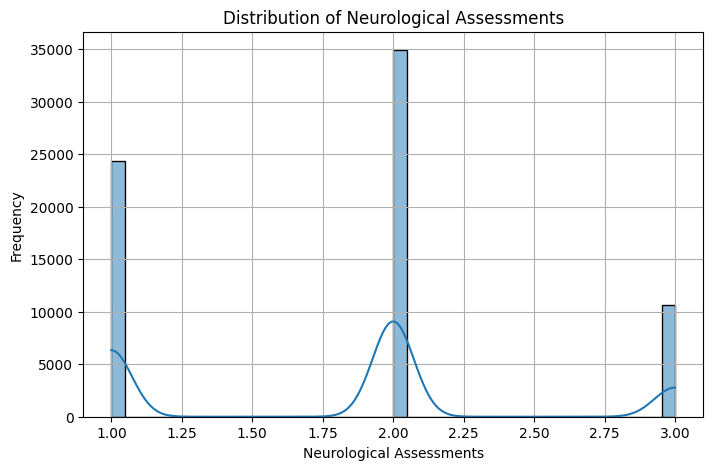

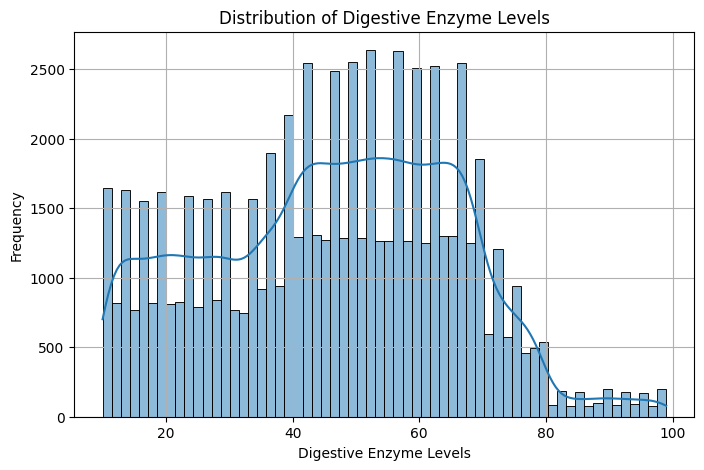

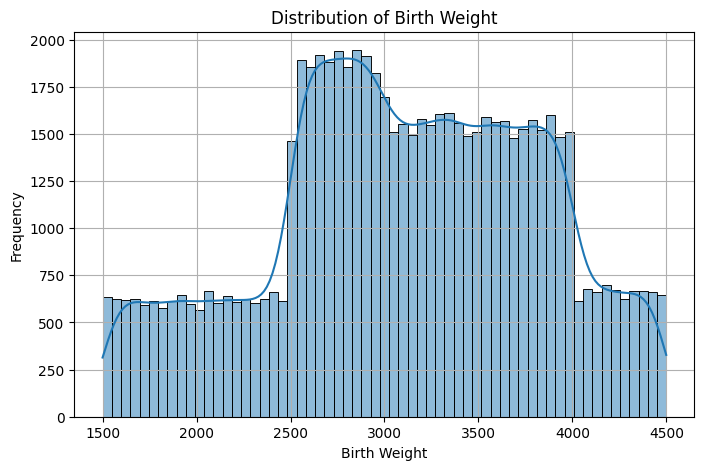

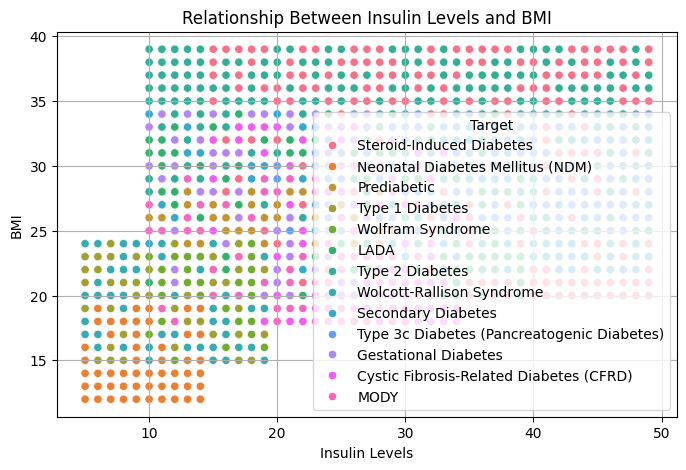

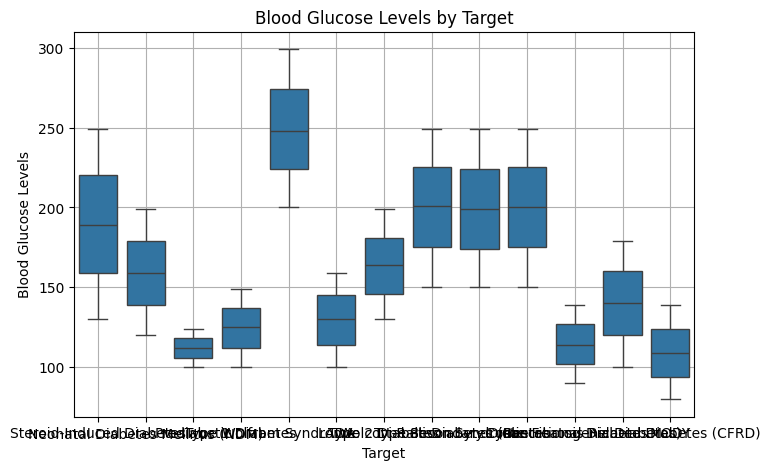

In [34]:

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

if 'Insulin Levels' in df.columns and 'BMI' in df.columns and 'Target' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x='Insulin Levels', y='BMI', hue='Target')
    plt.title("Relationship Between Insulin Levels and BMI")
    plt.xlabel("Insulin Levels")
    plt.ylabel("BMI")
    plt.legend(title="Target")
    plt.grid(True)
    plt.show()

if 'Target' in df.columns and 'Blood Glucose Levels' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Target', y='Blood Glucose Levels')
    plt.title("Blood Glucose Levels by Target")
    plt.xlabel("Target")
    plt.ylabel("Blood Glucose Levels")
    plt.grid(True)
    plt.show()


## **Part 4: Data Cleaning**


In [35]:

def handle_outliers(df, columns):
    """Cap outliers in the specified numerical columns using IQR."""
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

X_cleaned = handle_outliers(X.copy(), numerical_features)


## **Part 5: Preprocessed Data**

In [36]:

preprocessed_pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore')),
        ]), categorical_features)
    ])),
    ('pca', PCA(n_components=0.95))
])

X_preprocessed = preprocessed_pipeline.fit_transform(X_cleaned)

pca_step = preprocessed_pipeline.named_steps['pca']
print("PCA Number of Components:", pca_step.n_components_)


PCA Number of Components: 34


## **Part 6: Raw Data Preprocessing**

In [37]:

raw_pipeline = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

X_raw = raw_pipeline.fit_transform(X)


## **Part 7: Train-Test Split**

In [38]:

X_train_preprocessed, X_test_preprocessed, y_train_preprocessed, y_test_preprocessed = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42
)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)


## **Part 8: Train Random Forest Models**

In [39]:
rf_preprocessed = RandomForestClassifier(random_state=42)
rf_preprocessed.fit(X_train_preprocessed, y_train_preprocessed)
y_pred_preprocessed = rf_preprocessed.predict(X_test_preprocessed)

rf_raw = RandomForestClassifier(random_state=42)
rf_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = rf_raw.predict(X_test_raw)


## **Part 9: Evaluate and Compare Models**

In [40]:

preprocessed_metrics = classification_report(y_test_preprocessed, y_pred_preprocessed, output_dict=True)
raw_metrics = classification_report(y_test_raw, y_pred_raw, output_dict=True)

results_summary = pd.DataFrame({
    "Metrics": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Preprocessed Data": [
        preprocessed_metrics['accuracy'],
        preprocessed_metrics['weighted avg']['precision'],
        preprocessed_metrics['weighted avg']['recall'],
        preprocessed_metrics['weighted avg']['f1-score']
    ],
    "Raw Data Preprocessing": [
        raw_metrics['accuracy'],
        raw_metrics['weighted avg']['precision'],
        raw_metrics['weighted avg']['recall'],
        raw_metrics['weighted avg']['f1-score']
    ]
})

print("Comparison of Preprocessing Results")
print(results_summary)


Comparison of Preprocessing Results
     Metrics  Preprocessed Data  Raw Data Preprocessing
0   Accuracy           0.748286                0.893571
1  Precision           0.749029                0.898029
2     Recall           0.748286                0.893571
3   F1-Score           0.747015                0.892189
